# Pregunta 2:
# La gran cantidad de datos faltantes probablemente se debe a que la base de datos se construyó a partir de registros históricos, y de estaciones meteorologicas que no necesariamente operan de forma constante ni menos tienen una coherencia obligada.

In [1]:
#pregunta 3 a continuación:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression

In [3]:
DF = pd.read_csv('C:/Users/icald/OneDrive/Documentos/Caudales/desafio_spike_cuencas-master/caudal_extra.csv')
DF = DF.dropna()
DF.drop(['institucion','fuente', 'altura','latitud','longitud','cantidad_observaciones'],axis=1,inplace=True)
pd.options.mode.chained_assignment = None


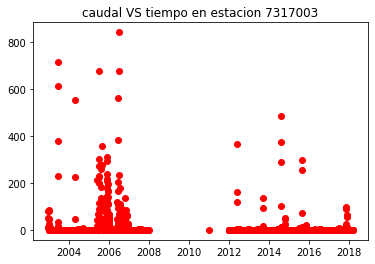

In [5]:
#3.a
f1 = pd.to_datetime('1960-01-01', utc = True)
f2 = pd.to_datetime('2019-10-17', utc = True)

def plot_unacolumna(dataframe,estacion, columna, fecha_ini, fecha_fin):
    #Estación debe ser int, columna string, pero fecha inicial y final como timestamp
    df = dataframe[dataframe['codigo_estacion']==estacion]
    aux = pd.to_datetime(df['fecha'], utc = True)
    df = df[(aux > fecha_ini) & (aux < fecha_fin)]
    x = pd.to_datetime(df['fecha'])
    y = df[columna]

    plt.figure()
    plt.plot_date(x, y,'ro')
    plt.title(columna + ' VS tiempo en estacion ' + str(estacion))
    plt.show()
    return

plot_unacolumna(DF,7317003,"caudal", f1, f2)

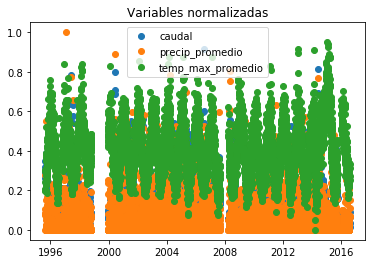

In [6]:
#3.b
def plot_variascolumnas(dataframe,estacion, columnas, fecha_ini, fecha_fin):
    #asumiendo que estacion y columna entran como string, pero fecha inicial y final con el formato dado
    df = dataframe[dataframe['codigo_estacion']==estacion]
    aux = pd.to_datetime(df['fecha'])
    df = df[(aux > fecha_ini) & (aux < fecha_fin)]
    x = pd.to_datetime(df['fecha'])
    for i in colu:
        y=(df[columnas[i]]-df[columnas[i]].min())/(df[columnas[i]].max())
        plt.plot_date(x,y,label = columnas[i])
    plt.legend()
    plt.title('Variables normalizadas')
    plt.show()
    return

colu = {'c1': 'caudal', 'c2': 'precip_promedio', 'c3':'temp_max_promedio'}
plot_variascolumnas(DF,10414001,colu, f1, f2)

In [10]:
#pregunta 4
A = pd.to_datetime(DF['fecha'][:])
l = DF.shape[1]
DF.insert(l,'month',A.dt.month)
DF.insert(l+1,'caudal_extremo',np.zeros(len(DF)))
DF.insert(l+2,'temp_extremo',np.zeros(len(DF)))
DF.insert(l+3,'precip_extremo',np.zeros(len(DF)))

In [11]:
meses = [1,4,7,10]
for j in meses:
    for i in DF['codigo_estacion'][:].unique():
        df = DF.loc[(DF['codigo_estacion']==i) & (DF['month'] >=j) & (DF['month'] <(j+3))]          
        if len(df)!=0:
            tcrit = np.percentile(df['temp_max_promedio'],95)
            pcrit = np.percentile(df['precip_promedio'],95)
            ccrit = np.percentile(df['caudal'],95)
            DF['temp_extremo'][df.index]= (df['temp_max_promedio']>tcrit)*1
            DF['precip_extremo'][df.index]= (df['precip_promedio']>pcrit)*1
            DF['caudal_extremo'][df.index]= (df['caudal']>ccrit)*1

#Si es una forma razonable de definir un evento extremo. Otra forma en que lo analizaría sería comparando
#las variables vs un valor fijo de acuerdo a los primeros años de los que se cuenta con información. De forma que si
#para una temporada, la variable cambia mucho respecto al promedio fijado, se considera evento extremo.

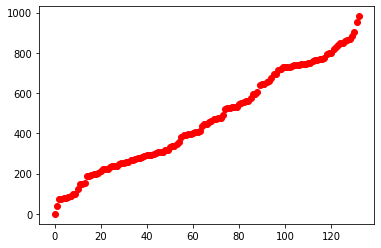

Diferencias de caudal en distintas cuencas de 943.0 eventos


In [12]:
#Pregunta 5: análisis de Caudal extremo

cau_ex = []          
cod = DF['codigo_estacion'][:].unique()
for i in cod:
    cau_ex.append(sum(DF['caudal_extremo'].loc[(DF['codigo_estacion']==i)]))

cau_ex = np.sort(cau_ex)
plt.figure() 
plt.plot(cau_ex,'ro') 
plt.show()   

print('Diferencias de caudal en distintas cuencas de ' + str(cau_ex[-1] - cau_ex[1]) + ' eventos')

#Este gráfico no tiene valor físico (ya que el eje x es arbitrario), pero sirve para ver las grandes diferencias entre
#distintas cuencas, que llegan a 943 eventos en el periodo.

In [13]:
#Pregunta 6:
ty = []
cy = []
py = []

x = A.dt.year.unique()

In [14]:
for i in x:
    ty.append(sum(DF['temp_extremo'][pd.to_datetime(DF['fecha']).dt.year == i]))
    cy.append(sum(DF['caudal_extremo'][pd.to_datetime(DF['fecha']).dt.year == i]))
    py.append(sum(DF['precip_extremo'][pd.to_datetime(DF['fecha']).dt.year == i]))

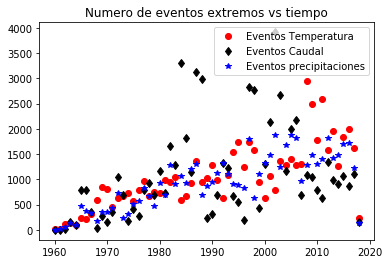

In [15]:
plt.figure()
plt.plot(A.dt.year.unique(),ty,'ro',label='Eventos Temperatura')
plt.plot(A.dt.year.unique(),cy,'kd',label='Eventos Caudal')
plt.plot(A.dt.year.unique(),py,'b*',label='Eventos precipitaciones')
plt.title('Numero de eventos extremos vs tiempo')
plt.legend()
plt.show() 

Se puede ver que el número de eventos extremos va en aumento, en las tres variables analizadas. Se aprecia una tendencia
aproximadamente lineal, especialmente en los eventos de temperatura y precipitaciones (lo que se puede explicar por 
ser variables con mayor independencia, en cambio los eventos de caudal dependerán de las precipitaciones, además de 
deshielos, por lo que es esperable una mayor variabilidad)

In [29]:
x = x.reshape(-1,1)

model = LinearRegression().fit(x, cy)
r2 = model.score(x,cy)

b = model.intercept_
m = model.coef_

print('Se estima un modelo y =' + str(m)+'x + ' + str(b))
print('Con r^2 de ' + str(r2))


Se estima un modelo y =[19.06282876]x + -36854.288427819985
Con r^2 de 0.12564231216917132


In [27]:
print('Para el año 2020 se predicen ' + str(int(m*2020+b)) + ' eventos extremos de caudal')

Para el año 2020 se predicen 1652 eventos extremos de caudal


Sin embargo, como r^2 es muy bajo, da cuenta que el modelo es incompleto, por lo que se deben buscar otros factores de ajuste, por ejemplo relacionar las cuencas con la cantidad de nieve aguas arriba de la estación de medición y las temperaturas, y con ello se podría obtener un mejor pronostico.